# Puget Sound Climatology Plot

In [1]:
import erddapy
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import xarray
import cf_xarray
import datetime
import netCDF4
from netCDF4 import Dataset

import matplotlib
from matplotlib import pyplot as plt

Downloading Data

In [2]:
def get_erddap_data(erddap_url, dataset, data_protocol="griddap", variables=None, constraints=None):
    """
    Function: get_erddap_data
    This function uses the erddapy python library to access data from ERDDAP servers,
    and to return it to users in convenient formats for python users.
    Data can be pulled from "tabledap" or "griddap" formats, with different
    output types, depending on the dap type.
    
    Inputs:
    erddap_url    - The url address of the erddap server to pull data from
    variables     - The selected variables within the dataset.
    data_protocol - The erddap data protocol for the chosen dataset.
                    Options include "tabledap" or "griddap"
                    The default option is given as "griddap"
    dataset       - The ID for the relevant dataset on the erddap server
                    If no variables are given, it is assumed that all variables
                    will be pulled.
    constraints   - These are set by the user to help restrict the data pull
                    to only the area and timeframe of interest.
                    If no constraints are given, all data in a dataset is pulled.
                    Constraints should be given as a dictionary, where
                    each entry is a bound and/or selection of a specific axis variable
                    Exs. {"longitude<=": "min(longitude)+10", "longitude>=": "0"}
                         {"longitude=": "140", "time>=": "max(time)-30"}
    
    Outputs:
    erddap_data   - This variable contains the pulled data from the erddap server.
                    If the data_protocol is "griddap",  then erddap_data is an xarray dataset
                    If the data_protocol is "tabledap", then erddap_data is a pandas dataframe
    """
    
    import erddapy
    from erddapy import ERDDAP
    import pandas as pd
    import xarray
    
    
    ############################################
    # Set-up the connection to the ERDDAP server
    ############################################
    
    # Connect to the erddap server
    e = ERDDAP(server=erddap_url, protocol=data_protocol, response='csv')
    
    # Identify the dataset of interest
    e.dataset_id = dataset
    
    
    #########################################
    # Pull the data, based upon protocol type
    #########################################
    
    # GRIDDAP Protocol
    if data_protocol == "griddap":
        
        # Initialize the connection
        e.griddap_initialize()

        # Update the constraints
        if constraints is not None:
            e.constraints.update(constraints)
            e.griddap_initialize()
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables

        erddap_data = e.to_xarray()
    
    # TABLEDAP Protocol
    elif data_protocol == "tabledap":

        # Update the constraints
        if constraints is not None:
            e.constraints = constraints
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables
            
        erddap_data = e.to_pandas()
    
    # Invalid protocol given
    else:
        print('Invalid ERDDAP protocol. Given protocol is: ' + data_protocol)
        print('Valid protocols include "griddap" or "tabledap". Please restart and try again with a valid protocol')
        erddap_data = None
    
    
    #############################
    return erddap_data

Extracting Climatology Data for Plotting at Specific Depth for Two Mooring Sub-stations

In [3]:
nwem_url = 'http://nwem.apl.washington.edu/erddap'

nwem_dataset1 = 'orca3_L3_depth_climatology_025'
nwem_dataset2 = 'npby1_L3_depth_climatology_025'

variables = ["sea_water_temperature",
             "sea_water_practical_salinity","mass_concentration_of_oxygen_in_sea_water"]

constraints = {"time>=":datetime.datetime(1970,1,1).strftime('%Y-%m-%dT%H:%M:%SZ')}
#constraints = None
#constraints = {"cast_start_time>=": "max(cast_start_time)-365"}

nwem_grid1 = get_erddap_data(nwem_url, nwem_dataset1, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

nwem_grid2 = get_erddap_data(nwem_url, nwem_dataset2, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

In [4]:
#nwem_grid2

In [5]:
ds1=nwem_grid1; ds2=nwem_grid2; 

In [6]:
# ds1.sea_water_temperature.values ds1.sea_water_temperature.shape

In [7]:
depth1=np.array(ds1.depth.values[:]); depth2=np.array(ds2.depth.values[:]); 
date1=np.array(ds1.time.values[:]); date2=np.array(ds2.time.values[:])#325
depth_l="50"

In [8]:
date1= np.array([pd.Timestamp(date).dayofyear for date in date1]); date2= np.array([pd.Timestamp(date).dayofyear for date in date2]); 

In [9]:
str1="sea_water_temperature"; str2="sea_water_practical_salinity";str3='mass_concentration_of_oxygen_in_sea_water';

In [10]:
var1_sst=ds1[str1]; var1_sss=ds1[str2]; var1_oxy=ds1[str3]; 

var2_sst=ds2[str1]; var2_sss=ds2[str2]; var2_oxy=ds2[str3]; 

In [11]:
var1_sst=var1_sst.assign_coords(time=("time",date1))
var1_sss=var1_sss.assign_coords(time=("time",date1))
var1_oxy=var1_oxy.assign_coords(time=("time",date1))

var2_sst=var2_sst.assign_coords(time=("time",date2))
var2_sss=var2_sss.assign_coords(time=("time",date2))
var2_oxy=var2_oxy.assign_coords(time=("time",date2))

In [12]:
tser1_sst=var1_sst.isel(depth=int(depth_l)); tser2_sst=var2_sst.isel(depth=int(depth_l))
tser1_sss=var1_sss.isel(depth=int(depth_l)); tser2_sss=var2_sss.isel(depth=int(depth_l))
tser1_oxy=var1_oxy.isel(depth=int(depth_l)); tser2_oxy=var2_oxy.isel(depth=int(depth_l))       

Plotting the Climatology Temp, Salinity, and Oxygen at depth for the two sub-stations Orca3 and Nbpy1

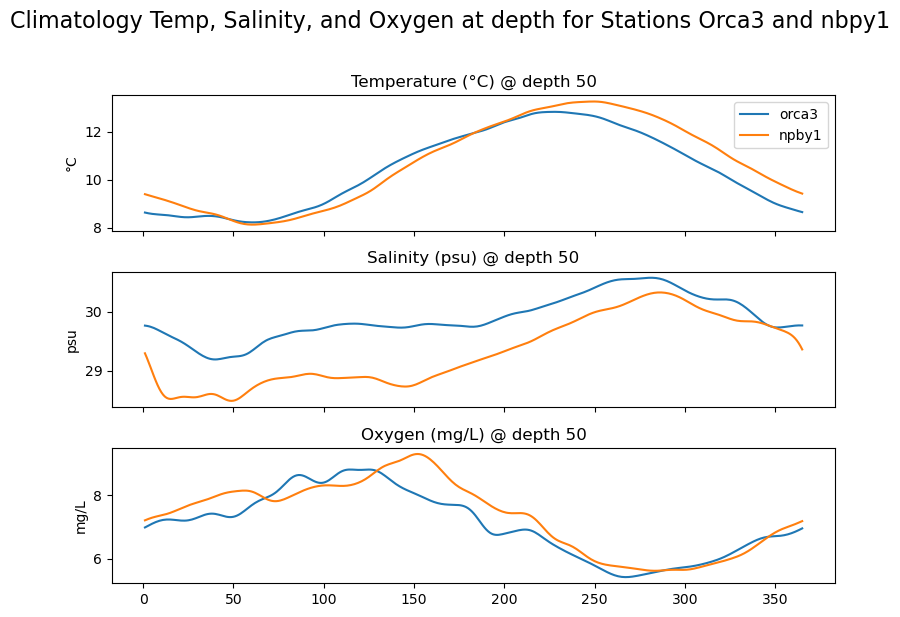

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))  # Share x-axis
t1 = ax1.plot(date1, tser1_sst,label='orca3'); t1_1=ax1.plot(date2, tser2_sst,label='npby1');
t2 = ax2.plot(date1, tser1_sss); t2_2 = ax2.plot(date2, tser2_sss)
t3 = ax3.plot(date1, tser1_oxy); t3_2 = ax3.plot(date2, tser2_oxy)


ax1.set_title("Temperature (°C) @ depth " + depth_l)
ax1.set_xlabel("")
ax1.set_ylabel("°C")
#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
ax1.set_xticklabels([])
ax1.legend()

ax2.set_title("Salinity (psu) @ depth " + depth_l)
ax2.set_xlabel("")
ax2.set_ylabel("psu")
#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
ax2.set_xticklabels([])

ax3.set_title("Oxygen (mg/L) @ depth " + depth_l)
ax3.set_xlabel("")
ax3.set_ylabel("mg/L")

#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
#ax2.set_xticklabels([])
f.suptitle("Climatology Temp, Salinity, and Oxygen at depth for Stations Orca3 and nbpy1", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Data Preparation for Climatology Depth Distribution Plots 

In [14]:
sst1=var1_sst.transpose(); sst2=var2_sst.transpose();
sss1=var1_sss.transpose(); sss2=var2_sss.transpose();
oxy1=var1_oxy.transpose(); oxy2=var2_oxy.transpose();

In [15]:
formatted_time = date1
tick_positions = np.linspace(0, len(date1) - 1, 6, dtype=int)
tick_labels = [formatted_time[i] for i in tick_positions]

 Climatology  Plot of Temperature, Salinity, and Oxygen at Orca3 Station

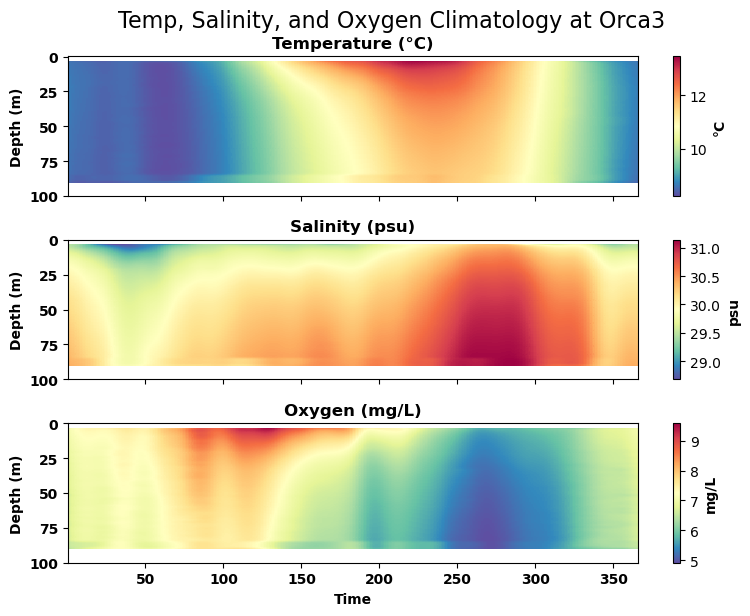

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))  # Share x-axis

# Plot Temperature subplot
sc1 = ax1.pcolor(date1, depth1, sst1, cmap="Spectral_r")
ax1.set_title("Temperature (°C)")
ax1.set_xlabel("")
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()  # Invert y axis
#ax1.set_xticks(date[tick_positions])
ax1.set_xticklabels([])

# Plot Salinity subplot
sc2 = ax2.pcolor(date1, depth1, sss1, cmap="Spectral_r")
ax2.set_title("Salinity (psu)")
ax2.set_xlabel("")
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()  # Invert y axis
#ax2.set_xticks(date[tick_positions])
ax2.set_xticklabels([])

# Plot Oxygen subplot
sc3 = ax3.pcolor(date1, depth1, oxy1, cmap="Spectral_r")
ax3.set_title("Oxygen (mg/L)")
ax3.set_ylabel("Depth (m)")
ax3.set_xlabel("Time")
#ax3.xaxis.set_major_locator(plt.FixedLocator(tick_positions))
#ax3.set_xticks(date[tick_positions])  # Set tick positions for the third row
#ax3.set_xticklabels(tick_labels, ha='center')  # Set tick labels for the third row
ax3.invert_yaxis()  # Invert y axis

# Add colorbars
cbar1 = f.colorbar(sc1, ax=ax1, orientation='vertical')
cbar1.ax.set_ylabel('°C',fontweight='bold')
cbar1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2 = f.colorbar(sc2, ax=ax2, orientation='vertical')
cbar2.ax.set_ylabel('psu',fontweight='bold')
cbar2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight


cbar3 = f.colorbar(sc3, ax=ax3, orientation='vertical')
cbar3.ax.set_ylabel('mg/L',fontweight='bold')
cbar3.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight


for ax in [ax1, ax2, ax3]:
    ax.set_title(ax.get_title(), fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontweight='bold')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
# Adjust layout
plt.tight_layout()
f.suptitle("Temp, Salinity, and Oxygen Climatology at Orca3 ", fontsize=16, y=1.02)
plt.show()

Comparing Climatology of Vertical Temperature, Salinity, and Oxygen of two Sub-Stations

In [ ]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))  # 3 rows, 2 columns

# Plot Temperature subplots
sc1_1 = axes[0, 0].pcolor(date1, depth1, sst1, cmap="Spectral_r", vmin=9,vmax=19)
axes[0, 0].set_title("Temperature (°C) - Orca3")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("Depth (m)")
axes[0, 0].invert_yaxis()  # Invert y axis
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylim([90, 0])  # Set y-axis range
#axes[0, 0].set_clim([10, 22])

sc1_2 = axes[0, 1].pcolor(date2, depth2, sst2, cmap="Spectral_r", vmin=9,vmax=19)
axes[0, 1].set_title("Temperature (°C) - npby1")
axes[0, 1].set_xlabel("")
#axes[0, 1].set_ylabel("Depth (m)")
axes[0, 1].invert_yaxis()  # Invert y axis
axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylim([90, 0])  # Set y-axis range

# Plot Salinity subplots
sc2_1 = axes[1, 0].pcolor(date1, depth1, sss1, cmap="Spectral_r", vmin=25,vmax=31)
axes[1, 0].set_title("Salinity (psu) - Orca3")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("Depth (m)")
axes[1, 0].invert_yaxis()  # Invert y axis
axes[1, 0].set_xticklabels([])
axes[1, 0].set_ylim([90, 0])  # Set y-axis range

sc2_2 = axes[1, 1].pcolor(date2, depth2, sss2, cmap="Spectral_r",  vmin=25,vmax=31)
axes[1, 1].set_title("Salinity (psu) - npby1")
axes[1, 1].set_xlabel("")
#axes[1, 1].set_ylabel("Depth (m)")
axes[1, 1].invert_yaxis()  # Invert y axis
axes[1, 1].set_xticklabels([])
axes[1, 1].set_ylim([90, 0])  # Set y-axis range

# Plot Oxygen subplots
sc3_1 = axes[2, 0].pcolor(date1, depth1, oxy1, cmap="Spectral_r",vmin=0,vmax=10)
axes[2, 0].set_title("Oxygen (mg/L) - Orca3")
axes[2, 0].set_ylabel("Depth (m)")
axes[2, 0].set_xlabel("Time")
axes[2, 0].invert_yaxis()  # Invert y axis
axes[2, 0].set_ylim([90, 0])  # Set y-axis range

sc3_2 = axes[2, 1].pcolor(date2, depth2, oxy2, cmap="Spectral_r",vmin=0,vmax=10)
axes[2, 1].set_title("Oxygen (mg/L) - npby1")
axes[2, 1].set_ylabel("Depth (m)")
axes[2, 1].set_xlabel("Time")
axes[2, 1].invert_yaxis()  # Invert y axis
axes[2, 1].set_ylim([90, 0])  # Set y-axis range

# Add colorbars
cbar1_1 = f.colorbar(sc1_1, ax=axes[0, 0], orientation='vertical')
cbar1_1.ax.set_ylabel('°C', fontweight='bold')
cbar1_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar1_2 = f.colorbar(sc1_2, ax=axes[0, 1], orientation='vertical')
cbar1_2.ax.set_ylabel('°C', fontweight='bold')
cbar1_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2_1 = f.colorbar(sc2_1, ax=axes[1, 0], orientation='vertical')
cbar2_1.ax.set_ylabel('psu', fontweight='bold')
cbar2_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2_2 = f.colorbar(sc2_2, ax=axes[1, 1], orientation='vertical')
cbar2_2.ax.set_ylabel('psu', fontweight='bold')
cbar2_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar3_1 = f.colorbar(sc3_1, ax=axes[2, 0], orientation='vertical')
cbar3_1.ax.set_ylabel('mg/L', fontweight='bold')
cbar3_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar3_2 = f.colorbar(sc3_2, ax=axes[2, 1], orientation='vertical')
cbar3_2.ax.set_ylabel('mg/L', fontweight='bold')
cbar3_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

# Adjust layout
plt.tight_layout()
f.suptitle("Climatology Comparison of Temp, Salinity, and Oxygen for Stations Orca3 and npby1", fontsize=16, y=1.02)
plt.show()

End of Climatology Plotting